# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [var_smoothing](#var_smoothing)
* [n_estimators](#n_estimators)
* [Discussion](#Discussion)

# Introduction

After rounds of feature engineering, visualization & exploration, and tuning various aspects of the classification pipeline, we are about to create our first prototype classifier using a bagged GaussianNB. In this notebook, we perform a grid search over var_smoothing using out-of-bag accuracy instead of cross validation. Fixing this var_smoothing to the best value observed, we perform a grid search for n_estimators of the bagging meta-classifier.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%matplotlib widget

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.42 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final features
FEATURES_FOLDER = "../19.0-mic-extract_FRILL-based_features_from_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 102 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "lang1",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(unscaled=False) -> pd.DataFrame:
    """Loads the FRILL-based features"""
    if unscaled:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/unscaled_features_ready_for_selection.feather"
        ).set_index("id")
    else:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/features_ready_for_selection.feather"
        ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data(unscaled=True)
labels = load_labels()
y_true = labels.valence
gnb_features = ["spherical-LDA1", "spherical-LDA2"]
assert all(data.index == labels.index)
_ = gc_collect()

time: 283 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 118 entries, theta_LDA1+LDA2 to LDA-ocSVM_poly6_pos
dtypes: float64(118)
memory usage: 78.8 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          86752 non-null  category
 1   speaker_id      86752 non-null  category
 2   speaker_gender  86752 non-null  category
 3   emo             86752 non-null  category
 4   valence         86752 non-null  int8    
 5   lang1           86752 non-null  category
dtypes: category(5), int8(1)
memory usage: 1.3 MB
time: 39 ms


# var_smoothing

In [7]:
df = data.loc[:, gnb_features]
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
make_gnb = lambda var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    # verbose=1,
).fit(df, y_true)
for hp in tqdm(np.random.uniform(0.0, 1.2, size=500)):
    gnb = make_gnb(hp)
    results["var_smoothing"].append(hp)
    results["oob_score"].append(gnb.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

  0%|          | 0/500 [00:00<?, ?it/s]

time: 12min 59s


     var_smoothing  oob_score  log_loss     auroc
496       0.005401   0.880233  0.352697  0.969671
192       0.006047   0.880233  0.352322  0.969688
200       0.010465   0.879945  0.349896  0.969800
284       0.010403   0.879934  0.349929  0.969798
465       0.013900   0.879807  0.348164  0.969882
324       0.015266   0.879715  0.347511  0.969914
366       0.017495   0.879599  0.346487  0.969964
438       0.021405   0.879426  0.344806  0.970048
165       0.022323   0.879392  0.344432  0.970067
151       0.026341   0.879254  0.342883  0.970147
     var_smoothing  oob_score  log_loss     auroc
14        0.103956   0.873870  0.331173  0.971077
212       0.108706   0.873663  0.331179  0.971111
66        0.109040   0.873628  0.331181  0.971113
487       0.101756   0.873893  0.331189  0.971061
197       0.100839   0.873951  0.331200  0.971055
141       0.100067   0.873997  0.331210  0.971049
283       0.098603   0.874020  0.331235  0.971037
139       0.096222   0.874354  0.331287  0.971019


<AxesSubplot:xlabel='var_smoothing'>

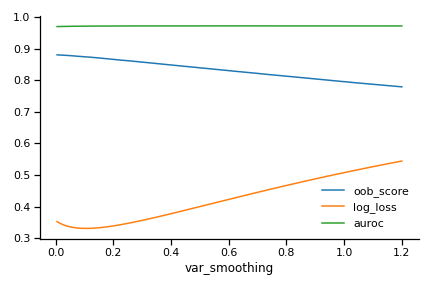

time: 312 ms


In [8]:
df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/var_smoothing_results_uniform.feather")

With a log uniform distribution instead of uniform

  0%|          | 0/500 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
433       0.001104   0.880418  0.355328  0.969553
46        0.001195   0.880406  0.355270  0.969556
391       0.001068   0.880406  0.355352  0.969552
296       0.000190   0.880383  0.355920  0.969527
71        0.001290   0.880383  0.355209  0.969558
392       0.000191   0.880383  0.355920  0.969527
63        0.000028   0.880372  0.356027  0.969522
340       0.000020   0.880372  0.356032  0.969522
47        0.000020   0.880372  0.356032  0.969522
451       0.000023   0.880372  0.356030  0.969522
     var_smoothing  oob_score  log_loss     auroc
352       0.106015   0.873697  0.331169  0.971092
362       0.114311   0.873202  0.331255  0.971148
283       0.094252   0.874585  0.331342  0.971003
457       0.093127   0.874631  0.331378  0.970994
0         0.119780   0.872867  0.331396  0.971182
54        0.090116   0.874735  0.331494  0.970969
259       0.125612   0.872510  0.331615  0.971216
70        0.125904   0.872533  0.331628  0.971218


<AxesSubplot:xlabel='var_smoothing'>

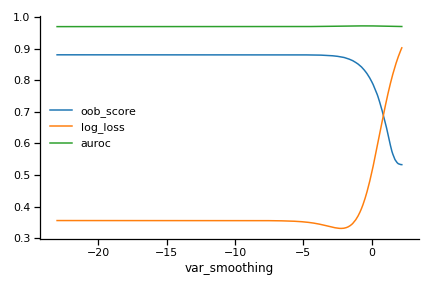

time: 12min 50s


In [9]:
df = data.loc[:, gnb_features]
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
make_gnb = lambda var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    # verbose=1,
).fit(df, y_true)
for hp in tqdm(loguniform.rvs(1e-10, 10, size=500)):
    gnb = make_gnb(hp)
    results["var_smoothing"].append(hp)
    results["oob_score"].append(gnb.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(
    f"{DATA_OUT_FOLDER}/var_smoothing_results_loguniform.feather"
)

# scale and plot
df.loc[:, "var_smoothing"] = np.log(df.loc[:, "var_smoothing"])
df.plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

Let's take a closer look near 0.

  0%|          | 0/500 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
2         0.001109   0.880429  0.355325  0.969553
27        0.001033   0.880383  0.355374  0.969551
151       0.000979   0.880383  0.355409  0.969550
348       0.000013   0.880372  0.356036  0.969522
128       0.000017   0.880372  0.356034  0.969522
441       0.000056   0.880372  0.356009  0.969523
352       0.000043   0.880372  0.356017  0.969523
246       0.000028   0.880372  0.356027  0.969522
413       0.000026   0.880372  0.356028  0.969522
428       0.000023   0.880372  0.356030  0.969522
     var_smoothing  oob_score  log_loss     auroc
186       0.089905   0.874746  0.331503  0.970967
208       0.128466   0.872337  0.331747  0.971232
147       0.130838   0.872084  0.331868  0.971245
67        0.080458   0.875519  0.332057  0.970883
461       0.080064   0.875599  0.332087  0.970879
129       0.072837   0.875991  0.332728  0.970808
193       0.147674   0.870504  0.333006  0.971328
35        0.148097   0.870447  0.333041  0.971329


<AxesSubplot:xlabel='var_smoothing'>

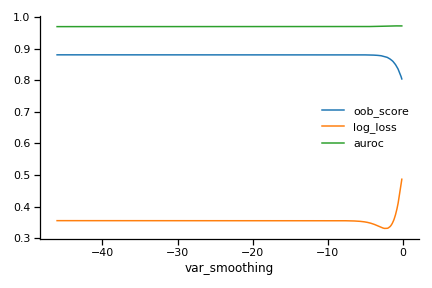

time: 13min 25s


In [10]:
df = data.loc[:, gnb_features]
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
make_gnb = lambda var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    # verbose=1,
).fit(df, y_true)
for hp in tqdm(loguniform.rvs(1e-20, 1.0, size=500)):
    gnb = make_gnb(hp)
    results["var_smoothing"].append(hp)
    results["oob_score"].append(gnb.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(
    f"{DATA_OUT_FOLDER}/var_smoothing_results_loguniform.feather"
)

# scale and plot
df.loc[:, "var_smoothing"] = np.log(df.loc[:, "var_smoothing"])
df.plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

hardly makes a difference; what if it's 0?

In [11]:
df = data.loc[:, gnb_features]
gnb = BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=0.0),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    # verbose=1,
).fit(df, y_true)
print("OOB score", gnb.oob_score_)
print(
    "auroc", roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
)
print("log_loss", log_loss(y_true, y_pred))

OOB score 0.8803601069715972
auroc 0.9695215025075085
log_loss 0.356045284227066
time: 4.59 s


# n_estimators

  0%|          | 0/199 [00:00<?, ?it/s]

    n_estimators  oob_score  log_loss     auroc
27            29   0.880429  0.355890  0.969521
29            31   0.880429  0.355889  0.969524
25            27   0.880418  0.355954  0.969522
24            26   0.880418  0.355923  0.969523
26            28   0.880418  0.355911  0.969522
30            32   0.880418  0.355878  0.969525
22            24   0.880406  0.355806  0.969531
28            30   0.880406  0.355880  0.969523
18            20   0.880395  0.355873  0.969528
23            25   0.880395  0.355861  0.969526
   n_estimators  oob_score  log_loss     auroc
3             5   0.844603  0.354656  0.969577
4             6   0.858124  0.354727  0.969580
5             7   0.866147  0.354849  0.969562
2             4   0.823785  0.354931  0.969562
6             8   0.871277  0.354950  0.969560
1             3   0.792477  0.354983  0.969532
7             9   0.874700  0.355185  0.969548
8            10   0.876971  0.355254  0.969547
0             2   0.740479  0.355268  0.969512
9 

<AxesSubplot:xlabel='n_estimators'>

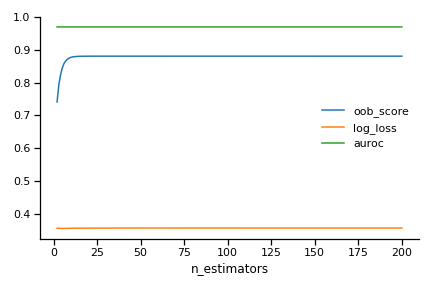

time: 9min 47s


In [12]:
df = data.loc[:, gnb_features]
results = {"n_estimators": [], "oob_score": [], "log_loss": [], "auroc": []}
# oob_score only available when warm_start=False
# gnb = BaggingClassifier(
#     base_estimator=GaussianNB(),
#     n_estimators=2,
#     oob_score=True,
#     warm_start=True,
#     n_jobs=-1,
#     random_state=SEED,
#     verbose=1,
# )
make_gnb = lambda n_estimators: BaggingClassifier(
    base_estimator=GaussianNB(),
    n_estimators=n_estimators,
    oob_score=True,
    warm_start=False,
    n_jobs=-1,
    random_state=SEED,
    # verbose=1,
)

# while gnb.n_estimators < 100:
for n in tqdm(range(2, 201)):
    # model = gnb.fit(df, y_true)
    model = make_gnb(n).fit(df, y_true)
    # results["n_estimators"].append(gnb.n_estimators)
    results["n_estimators"].append(n)
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(df), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))
    # gnb.n_estimators += 1

# save results
df = pd.DataFrame(results).sort_values(by="n_estimators", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/GNB_n_estimators_results.feather")

# plot
df.plot(x="n_estimators")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [14]:
print(df.sort_values(by="auroc", ascending=False).head(10))

    n_estimators  oob_score  log_loss     auroc
4              6   0.858124  0.354727  0.969580
3              5   0.844603  0.354656  0.969577
5              7   0.866147  0.354849  0.969562
2              4   0.823785  0.354931  0.969562
6              8   0.871277  0.354950  0.969560
7              9   0.874700  0.355185  0.969548
8             10   0.876971  0.355254  0.969547
11            13   0.879403  0.355468  0.969541
9             11   0.878228  0.355394  0.969541
14            16   0.880153  0.355587  0.969537
time: 7.1 ms


# Discussion

`var_smoothing` doesn't appear to be an important hyperparameter in this situation. Performance appears to cap at `n_estimators = 25`.

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [13]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 4185.689688205719 s
time: 253 ms


[^top](#Contents)